# PSTAT131 Final Project
## Analyzing the Impact of Individual's Background Factors on Job Placement
### Tianji Li
### UCSB Summer 2024

![Job Placement](https://dynamic.placementindia.com/blog_images/20210330112333_image1.jpg)

<a name="introduction"></a>

<a name="background"></a>

# Table of Contents
- [I. Introduction](#introduction)
  - [Background Information and Motivation](#background-information-and-motivation)
  - [Objectives](#objectives)
- [II. Data Description](#data-description)
  - [Data Loading](#data-loading)
  - [Data Organizing and Cleaning](#data-organizing-and-cleaning)
  - [Variable Selection](#variable-selection)
  - [Codebook](#codebook)
- [III. Exploratory Data Analysis](#exploratory-data-analysis)
  - [Exploring and Tidying the Raw Data](#exploring-and-tidying-the-raw-data)
  - [Factorization & Formatting](#factorization-&-formatting)
  - [Visual Exploratory Data Analysis](#visual-exploratory-data-analysis)
- [IV. Model Setup](#model-setup)
  - [Training & Test Spliting](#training-&-test-spliting)
  - [K-Fold Cross-Validation](#k-fold-cross-validation)
  - [Recipe](#recipe)
- [V. Model Building](#model-building)
  - [Model Specification](#model-specification)
  - [Workflow](#workflow)
  - [Grids](#grids)
  - [Tune Grid](#tune-grid)
  - [Metrics Collection](#metrics-collection)
- [VI. Model Result](#model-result)
- [VII. Model Fitting](#model-fitting)
- [VIII. Model Testing](#model-testing)
- [IX. Error Analysis](#error-analysis)
- [X. Conclusion](#conclusion)
- [XI. Sources](#sources)

## I. Introduction

<a name="Background Information and Motivation"></a>

<a name="background-information-and-motivation"></a>
### Background Information and Motivation
As a student nearing the end of my academic journey, I’ve been thinking a lot about the factors that influence job placement. Personally, I know how much effort goes into maintaining good grades, gaining work experience, and preparing for employment tests. But even with these efforts, the question remains: what really increases someone’s chances of getting hired?
This project is an opportunity for me to explore that question using real data. By diving into the relationship between academic performance, work experience, and job placement outcomes, I’m hoping to uncover patterns that reflect my own experiences and those of my peers. I’m particularly curious to see if certain factors, like degree scores or work experience, weigh more heavily in determining whether someone gets placed.

![Job Placement3](https://accountabilityresources.com/wp-content/uploads/2020/08/iStock-1138817616-2048x1356.jpg.webp)

<a name="objectives"></a>
### Objective
The goal of this project is to build a predictive model that can forecast whether an individual will secure a job placement. I’ll be working with a dataset from Kaggle called "Job Placement Dataset" that includes various educational and demographic details, such as secondary and higher secondary exam scores, degree percentages, work experience, and test scores. The outcome I’m predicting is a binary classification: “Placed” or “Not Placed.” I will find out which factors have the strongest influence on job placement, and use this information to create a model that can make accurate predictions.

### Library Loading

In [ ]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(kknn)
library(themis)
library(caret)
library(janitor)
library(ggplot2)
library(forcats)
library(rsample)
library(corrplot)
library(ranger)
library(vip)
library(pROC)
library(broom)
library(visdat)
library(reshape2)
library(rsample)
library(parsnip)
install.packages("xgboost")
library(xgboost)
install.packages("kernlab")
library(kernlab)

<a name="data-description"></a>
## II. Data Description

<a name="data-loading"></a>
### Data Loading 

In [2]:
placement <- read.csv("Job_Placement_Data.csv")
head(placement)

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed
6,M,55.00,Others,49.80,Others,Science,67.25,Sci&Tech,Yes,55.0,Mkt&Fin,51.58,Not Placed


<a name="data-organizing-and-cleaning"></a>
### Data Organizing and Cleaning

In [4]:
# Create a new column called 'Candidate_ID'
placement <- placement %>%
  mutate(Candidate_ID = row_number())  # Assigning unique candidate IDs

# Reorder the columns so that Candidate_ID comes first
placement <- placement %>%
  select(Candidate_ID, everything())

head(placement)

,Candidate_ID,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
,<int>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
2,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
3,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
4,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
5,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed
6,6,M,55.00,Others,49.80,Others,Science,67.25,Sci&Tech,Yes,55.0,Mkt&Fin,51.58,Not Placed


In [6]:
summary(placement)

  Candidate_ID      gender          ssc_percentage   ssc_board        
 Min.   :  1.0   Length:215         Min.   :40.89   Length:215        
 1st Qu.: 54.5   Class :character   1st Qu.:60.60   Class :character  
 Median :108.0   Mode  :character   Median :67.00   Mode  :character  
 Mean   :108.0                      Mean   :67.30                     
 3rd Qu.:161.5                      3rd Qu.:75.70                     
 Max.   :215.0                      Max.   :89.40                     
 hsc_percentage   hsc_board         hsc_subject        degree_percentage
 Min.   :37.00   Length:215         Length:215         Min.   :50.00    
 1st Qu.:60.90   Class :character   Class :character   1st Qu.:61.00    
 Median :65.00   Mode  :character   Mode  :character   Median :66.00    
 Mean   :66.33                                         Mean   :66.37    
 3rd Qu.:73.00                                         3rd Qu.:72.00    
 Max.   :97.70                                         Max.   :91

<a name="variable-selection"></a>
### Variable Selection

In [8]:
dim(placement)

[1] 215  14

The dataset consists of 215 rows and 14 columns, with various factors that could influence job placement outcomes. These include a range of educational, demographic, and work-related variables, such as ssc_percentage, hsc_percentage, degree_percentage, work_experience, and emp_test_percentage. Apart from Candidate ID and status, each of these factors plays a role in shaping an individual’s likelihood of securing a job. I plan to analyze the rest 12 variables to get a comprehensive understanding of their individual and collective impacts. 

In [10]:
# Double check column names
print(names(placement))

 [1] "Candidate_ID"        "gender"              "ssc_percentage"     
 [4] "ssc_board"           "hsc_percentage"      "hsc_board"          
 [7] "hsc_subject"         "degree_percentage"   "undergrad_degree"   
[10] "work_experience"     "emp_test_percentage" "specialisation"     
[13] "mba_percent"         "status"             


In [11]:
# Data Cleaning 
placement <- clean_names(placement)
head(placement)

,candidate_id,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
,<int>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
2,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
3,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
4,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
5,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed
6,6,M,55.00,Others,49.80,Others,Science,67.25,Sci&Tech,Yes,55.0,Mkt&Fin,51.58,Not Placed


Here, clean_names from "janitor" package standardized all the column names to lowercase so that they more consistent and easier to work with. By doing this, I can reduce potential errors and simplify the dataset for the next steps of the analysis. Once I've applied clean_names(), I'll be in a much better position to handle any missing data and tackle other cleaning tasks during the exploratory data analysis (EDA) phase.

<a name="codebook"></a>
### Codebook

Below is the codebook of my Job Placement Dataset with a brief description of each column based on its dataset structure.

#### Candidate_ID
* Description: A unique identifier assigned to each candidate.
* Type: Integer
* Values: Sequential numbers starting from 1 to 215.

#### Gender
* Description: Gender of the candidate.
* Type: Categorical
* Values:
"M" = Male
"F" = Female

#### ssc_percentage
* Description: Senior secondary (10th-grade) exam percentage.
* Type: Numeric (Percentage)
* Values: 0–100

#### ssc_board
* Description: The board of education for the senior secondary (SSC) exams.
* Type: Categorical
* Values:
"Central" = Central Board
"Others" = Other boards

#### hsc_percentage
* Description: Higher secondary (12th-grade) exam percentage.
* Type: Numeric (Percentage)
* Values: 0–100

#### hsc_board
* Description: The board of education for the higher secondary (HSC) exams.
* Type: Categorical
* Values:
"Central" = Central Board
"Others" = Other boards

#### hsc_subject
* Description: The subject of study during the higher secondary (HSC) level.
* Type: Categorical
* Values:
"Commerce"
"Science"
"Arts"

#### degree_percentage
* Description: Percentage obtained in the undergraduate degree.
* Type: Numeric (Percentage)
* Values: 0–100

#### undergrad_degree
* Description: The specialization of the candidate’s undergraduate degree.
* Type: Categorical
* Values:
"Sci&Tech" = Science and Technology
"Comm&Mgmt" = Commerce and Management

#### work_experience
* Description: Whether the candidate has prior work experience.
* Type: Categorical
* Values:
"Yes" = Candidate has prior work experience
"No" = Candidate has no prior work experience

#### emp_test_percentage
* Description: Percentage obtained in the employment aptitude test.
* Type: Numeric (Percentage)
* Values: 0–100

#### specialisation
* Description: MBA specialization.
* Type: Categorical
* Values:
"Mkt&Fin" = Marketing and Finance
"Mkt&HR" = Marketing and Human Resources

#### mba_percent
* Description: Percentage obtained in the MBA program.
* Type: Numeric (Percentage)
* Values: 0–100

#### status
* Description: The job placement outcome (target variable).
* Type: Categorical
* Values:
"Placed" = Candidate was placed in a job
"Not Placed" = Candidate was not placed in a job

<a name="exploratory-data-analysis"></a>
## III. Exploratory Data Analysis
<a name="exploring-and-tidying-the-raw-data"></a>
### Exploring and Tidying the Raw Data

In [16]:
summary(placement)

  candidate_id      gender          ssc_percentage   ssc_board        
 Min.   :  1.0   Length:215         Min.   :40.89   Length:215        
 1st Qu.: 54.5   Class :character   1st Qu.:60.60   Class :character  
 Median :108.0   Mode  :character   Median :67.00   Mode  :character  
 Mean   :108.0                      Mean   :67.30                     
 3rd Qu.:161.5                      3rd Qu.:75.70                     
 Max.   :215.0                      Max.   :89.40                     
 hsc_percentage   hsc_board         hsc_subject        degree_percentage
 Min.   :37.00   Length:215         Length:215         Min.   :50.00    
 1st Qu.:60.90   Class :character   Class :character   1st Qu.:61.00    
 Median :65.00   Mode  :character   Mode  :character   Median :66.00    
 Mean   :66.33                                         Mean   :66.37    
 3rd Qu.:73.00                                         3rd Qu.:72.00    
 Max.   :97.70                                         Max.   :91

In [17]:
# structure of placement dataset
str(placement)

'data.frame':	215 obs. of  14 variables:
 $ candidate_id       : int  1 2 3 4 5 6 7 8 9 10 ...
 $ gender             : chr  "M" "M" "M" "M" ...
 $ ssc_percentage     : num  67 79.3 65 56 85.8 ...
 $ ssc_board          : chr  "Others" "Central" "Central" "Central" ...
 $ hsc_percentage     : num  91 78.3 68 52 73.6 ...
 $ hsc_board          : chr  "Others" "Others" "Central" "Central" ...
 $ hsc_subject        : chr  "Commerce" "Science" "Arts" "Science" ...
 $ degree_percentage  : num  58 77.5 64 52 73.3 ...
 $ undergrad_degree   : chr  "Sci&Tech" "Sci&Tech" "Comm&Mgmt" "Sci&Tech" ...
 $ work_experience    : chr  "No" "Yes" "No" "No" ...
 $ emp_test_percentage: num  55 86.5 75 66 96.8 ...
 $ specialisation     : chr  "Mkt&HR" "Mkt&Fin" "Mkt&Fin" "Mkt&HR" ...
 $ mba_percent        : num  58.8 66.3 57.8 59.4 55.5 ...
 $ status             : chr  "Placed" "Placed" "Placed" "Not Placed" ...


In [18]:
# Check for missing values
colSums(is.na(placement))

candidate_id              gender      ssc_percentage           ssc_board 
                  0                   0                   0                   0 
     hsc_percentage           hsc_board         hsc_subject   degree_percentage 
                  0                   0                   0                   0 
   undergrad_degree     work_experience emp_test_percentage      specialisation 
                  0                   0                   0                   0 
        mba_percent              status 
                  0                   0

<a name="factorization-&-formatting"></a>
### Factorization & Formatting:
* I want to make sure that categorical variables like gender, work experience, and undergrad_degree are treated as factors.
* I also want to double check numerical data to see if they are in the correct format and scales.

In [21]:
# Converting categorical variables to factors
placement$gender <- as.factor(placement$gender)
placement$ssc_board <- as.factor(placement$ssc_board)
placement$hsc_board <- as.factor(placement$hsc_board)
placement$hsc_subject <- as.factor(placement$hsc_subject)
placement$undergrad_degree <- as.factor(placement$undergrad_degree)
placement$work_experience <- as.factor(placement$work_experience)
placement$specialisation <- as.factor(placement$specialisation)
placement$status <- as.factor(placement$status)

# Check data structure again
str(placement)

'data.frame':	215 obs. of  14 variables:
 $ candidate_id       : int  1 2 3 4 5 6 7 8 9 10 ...
 $ gender             : Factor w/ 2 levels "F","M": 2 2 2 2 2 2 1 2 2 2 ...
 $ ssc_percentage     : num  67 79.3 65 56 85.8 ...
 $ ssc_board          : Factor w/ 2 levels "Central","Others": 2 1 1 1 1 2 2 1 1 1 ...
 $ hsc_percentage     : num  91 78.3 68 52 73.6 ...
 $ hsc_board          : Factor w/ 2 levels "Central","Others": 2 2 1 1 1 2 2 1 1 1 ...
 $ hsc_subject        : Factor w/ 3 levels "Arts","Commerce",..: 2 3 1 3 2 3 2 3 2 2 ...
 $ degree_percentage  : num  58 77.5 64 52 73.3 ...
 $ undergrad_degree   : Factor w/ 3 levels "Comm&Mgmt","Others",..: 3 3 1 3 1 3 1 3 1 1 ...
 $ work_experience    : Factor w/ 2 levels "No","Yes": 1 2 1 1 1 2 1 2 1 1 ...
 $ emp_test_percentage: num  55 86.5 75 66 96.8 ...
 $ specialisation     : Factor w/ 2 levels "Mkt&Fin","Mkt&HR": 2 1 1 2 1 1 1 1 1 1 ...
 $ mba_percent        : num  58.8 66.3 57.8 59.4 55.5 ...
 $ status             : Factor w/ 2 levels

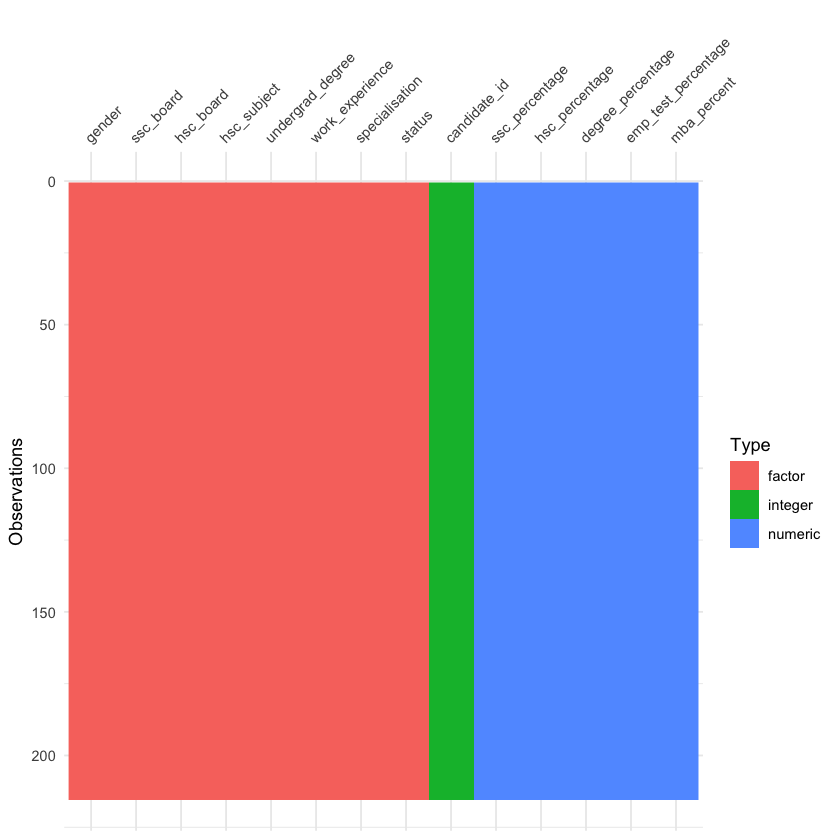

In [23]:
# visualize varibles and their corresponding types
vis_dat(placement)

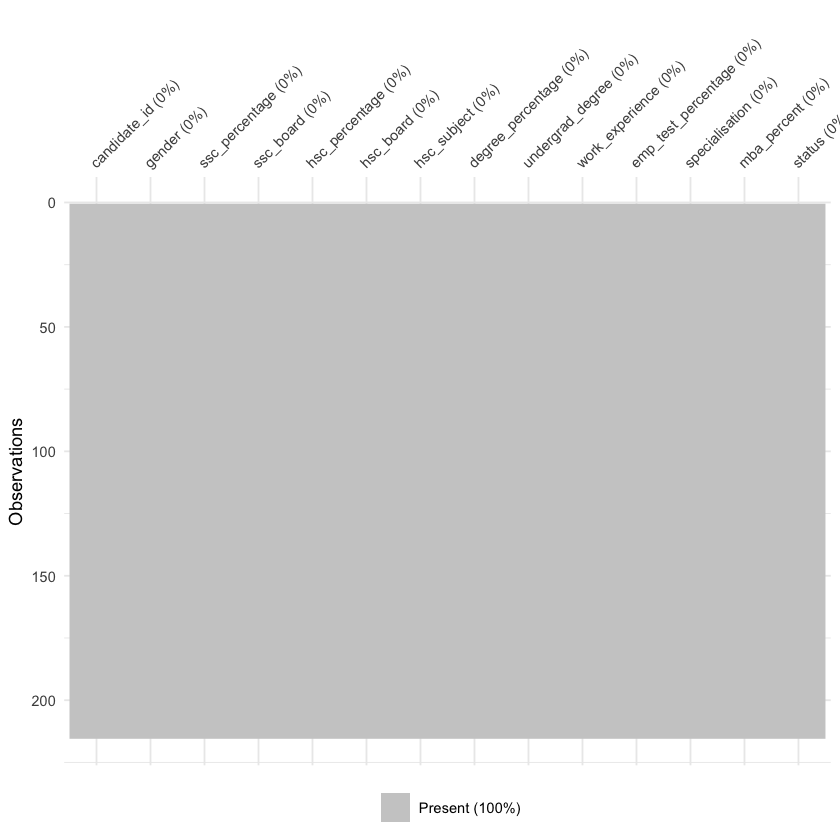

In [25]:
# visualizes missing data
vis_miss(placement)

From the above graph, I can confirm that my dataset is complete, with no missing values across any of the variables. Each column shows 0% missing data, so all observations are fully present for every variable. This allows me to proceed with my Exploratory Data Analysis without needing to worry about data imputation or handling missing entries. 

<a name="visual-exploratory-data-analysis"></a>
### Visual Exploratory Data Analysis

Visualization is a great way to explore data distribution, uncover relationships between variables, and detect potential outliers. I will begin by using a correlation plot to pinpoint the variables that have the strongest connections to job placement. This will allow me to concentrate on the most important factors that could influence placement outcomes and benefit both my analysis and model-building process. Along with numerical variables, I will also include other types of data in the analysis to ensure a comprehensive approach.

#### Corrplot

First, I will assess how individual candidate's attributes correlate with each other.


In [30]:
# correlation matrix
cor_matrix <- cor(placement[, sapply(placement, is.numeric)], use = "complete.obs")
print(cor_matrix)

                    candidate_id ssc_percentage hsc_percentage
candidate_id          1.00000000    -0.07815472    -0.08571138
ssc_percentage       -0.07815472     1.00000000     0.51147210
hsc_percentage       -0.08571138     0.51147210     1.00000000
degree_percentage    -0.08828133     0.53840400     0.43420581
emp_test_percentage   0.06363593     0.26199269     0.24511293
mba_percent           0.02232720     0.38847755     0.35482260
                    degree_percentage emp_test_percentage mba_percent
candidate_id              -0.08828133          0.06363593   0.0223272
ssc_percentage             0.53840400          0.26199269   0.3884776
hsc_percentage             0.43420581          0.24511293   0.3548226
degree_percentage          1.00000000          0.22447017   0.4023638
emp_test_percentage        0.22447017          1.00000000   0.2180547
mba_percent                0.40236377          0.21805467   1.0000000


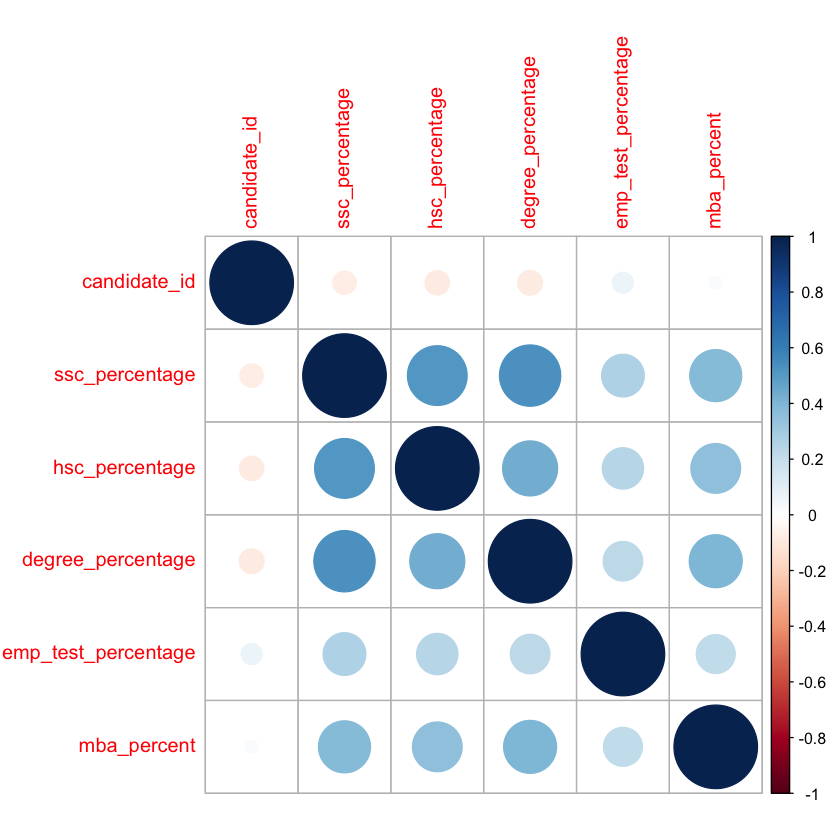

In [31]:
# correlation plot
corrplot(cor_matrix, method = "circle")

One of the strongest positive relationships is between ssc_percentage (10th grade scores) and degree_percentage (college scores). This suggests that students who do well in their secondary secondary exams also tend to do well in college. There is also a strong connection between ssc_percentage (10th grade scores) and hsc_percentage (12th grade scores). This suggests that 
students who do well in their secondary exams tend to do well in high school, as well. 

We also see that hsc_percentage (10th grade scores) has a moderate positive relationship with degree_percentage. This means that students who perform well in high school can possibly keep up their good performance later on. Same thing with mba_percentage and degree-percentage, which suggests students who perform well in college can possibly succeed in MBA. 

One thing I noticed is none of these factors have strong correlation with emp_test_percent. In other words, doing well in k12 schools and colleges does not really affect candidates' scores in employment test. It seems that ssc_percentage and hsc_percentage has a little more correlation than college and mba performances. This means that the employment test is likely to be tilted toward high school algebra stuffs rather than college math. From my recent experience of applying for jobs and taking employment test, this is actually the case for me. 

#### Histogram

Next, I will examine the distribution of degree_percentage, a crucial variable in predicting job placement. 

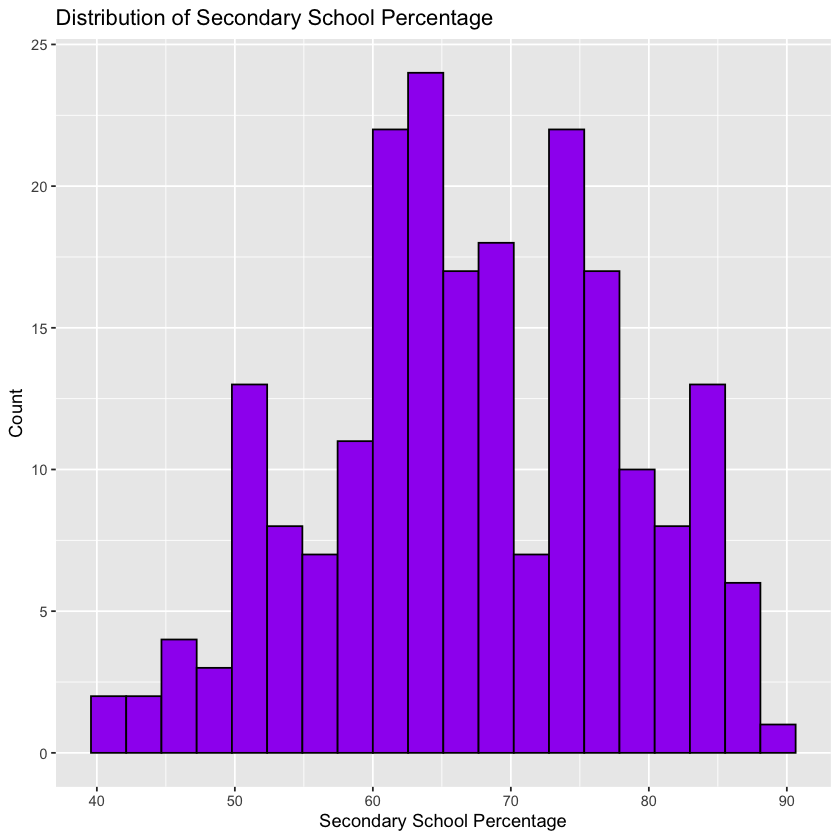

In [36]:
# Histogram for ssc_percentage
ggplot(placement, aes(x = ssc_percentage)) +
  geom_histogram(fill = 'purple', color = 'black', bins = 20) +
  labs(title = "Distribution of Secondary School Percentage", x = "Secondary School Percentage", y = "Count")

The distribution of ssc_percentage shows a fairly spread-out range, with a large number of students scoring between 50% and 70%. There is a peak around 60%, suggesting that many students tend to score in this range during their secondary school exams.

Performance Range: Most students have scores between 50% and 70%, indicating this is the common performance level. The spread shows some variation, but many students fall around these central values.

High and Low Performers: While the majority of students cluster around the middle, there are a few students who perform much better, with scores approaching 90%, as well as a smaller group with lower scores closer to 40%, showing some diversity in academic performance.

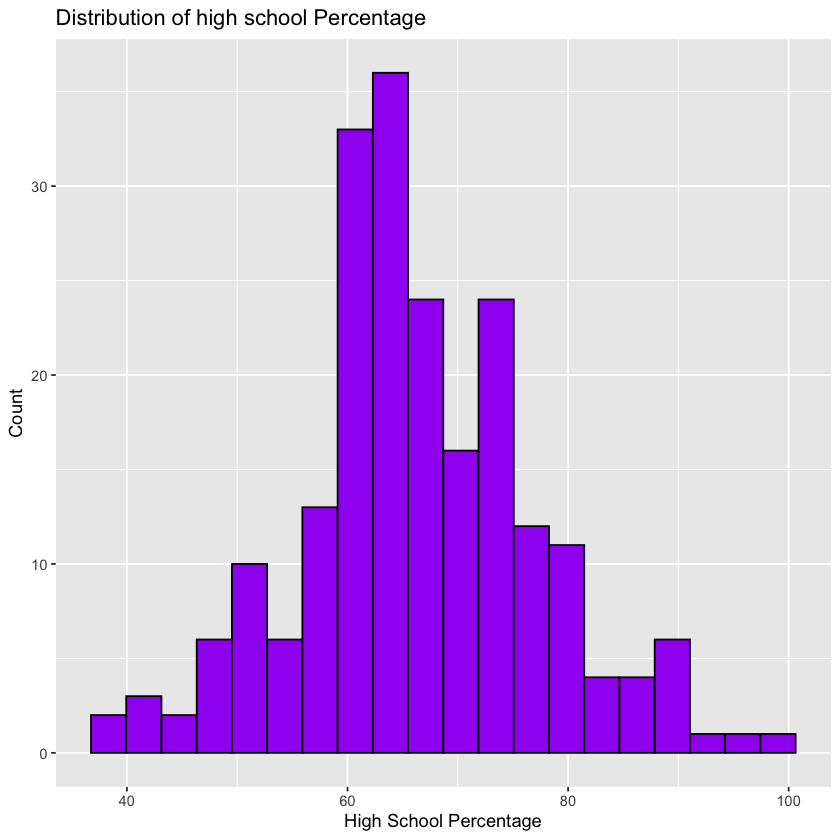

In [39]:
# Histogram for hsc_percentage
ggplot(placement, aes(x = hsc_percentage)) +
  geom_histogram(fill = 'purple', color = 'black', bins = 20) +
  labs(title = "Distribution of high school Percentage", x = "High School Percentage", y = "Count")

The distribution of hsc_percentage is centered around 60%, showing a similar pattern to the secondary school scores. There’s a noticeable peak at this point, suggesting that many students maintain similar performance between secondary and high school.

Performance Range: Most students have scores between 55% and 75%, indicating that this is the typical performance range. There is a bit more concentration around the 60% mark compared to secondary school scores.

High and Low Performers: The data reveals a few high-performing students with scores above 80%, as well as some lower-performing students with scores below 50%, indicating a similar diversity in performance to what was seen in secondary school.

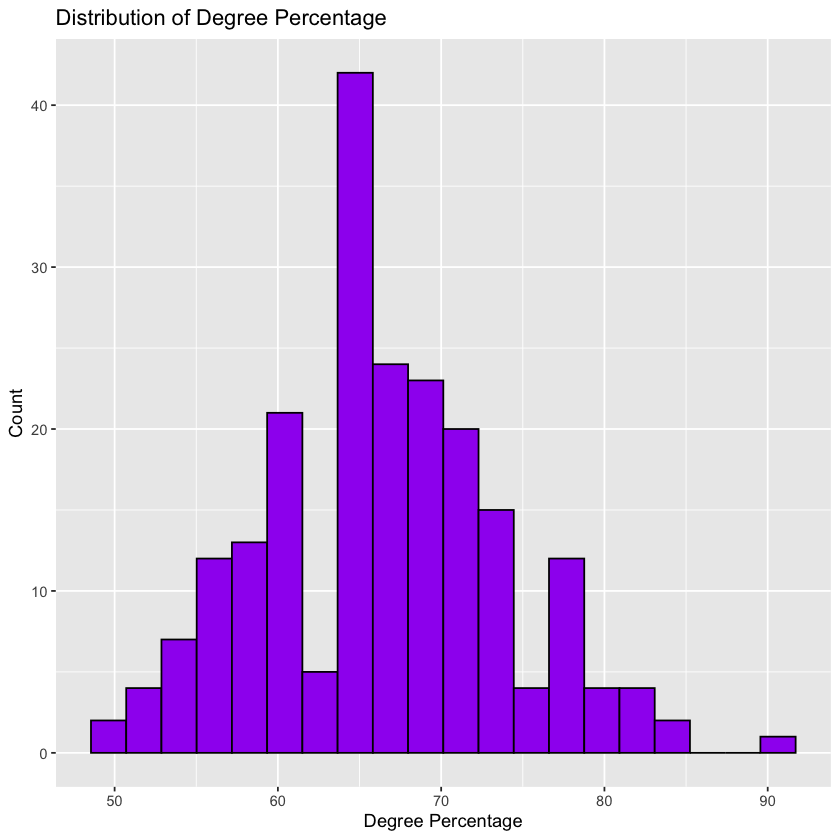

In [42]:
# Histogram for degree_percentage
ggplot(placement, aes(x = degree_percentage)) +
  geom_histogram(fill = 'purple', color = 'black', bins = 20) +
  labs(title = "Distribution of Degree Percentage", x = "Degree Percentage", y = "Count")

The distribution of degree_percentage shows a multi-modal pattern, with a notable peak around 60%. This suggests that a large portion of students tends to achieve scores around this range. Another smaller peak, occurs around 70%, shows that a significant group of students performs slightly better.

Performance Range: The bulk of the students fall between 55% and 75%. This indicates the typical performance range for most students. The spread of the distribution suggests that students' performance is varied, but many tend to cluster around specific score ranges.

High and Low Performers: While the majority of students fall within the central range, there are also a few outliers. On the higher end, some students have achieved scores above 85%, while at the lower end, there are students with scores closer to 50%, indicating a broader range of academic achievement.

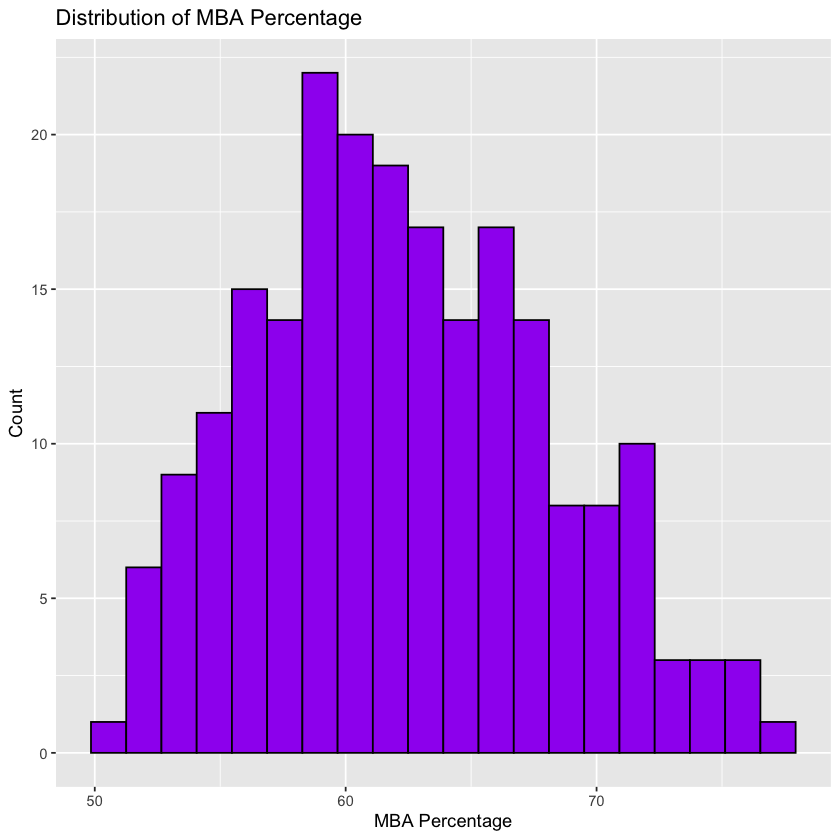

In [45]:
# Histogram for mba_percent
ggplot(placement, aes(x = mba_percent)) +
  geom_histogram(fill = 'purple', color = 'black', bins = 20) +
  labs(title = "Distribution of MBA Percentage", x = "MBA Percentage", y = "Count")

The distribution of mba_percent shows that most students score between 55% and 65%, with a clear peak around 60%. This indicates that MBA performance is relatively consistent for most students.

Performance Range: The majority of students fall within a narrow range of 55% to 65%, showing that most students perform similarly in their MBA programs.

High and Low Performers: While the majority of students cluster around the 60% mark, a smaller group performs significantly lower, scoring below 50%, and a few students score above 70%, showing a slight spread in performance.

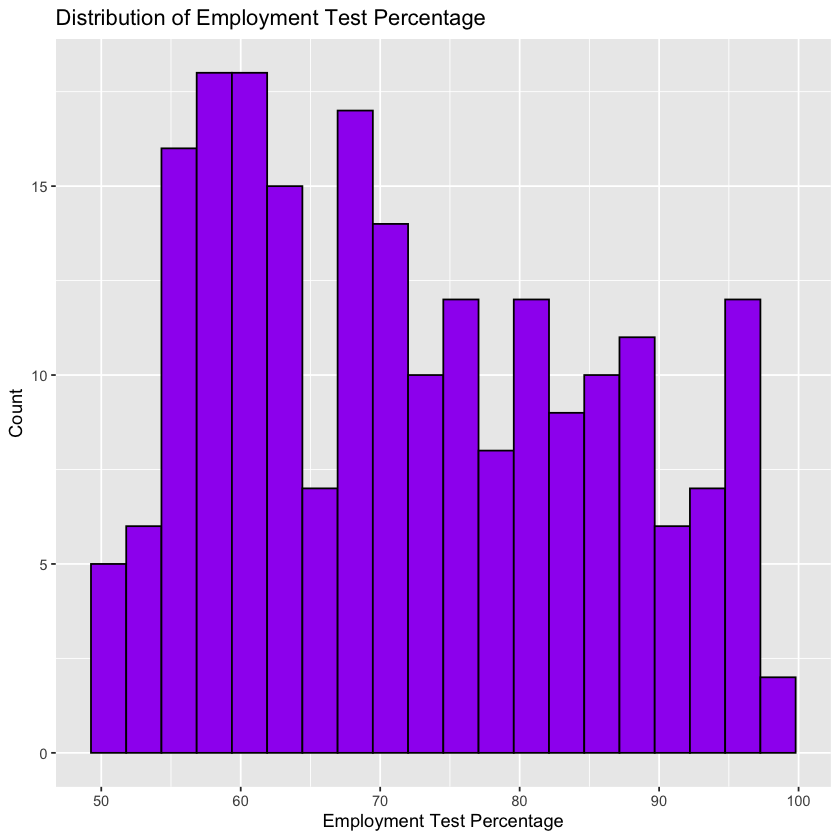

In [47]:
# Histogram for emp_test_percentage
ggplot(placement, aes(x = emp_test_percentage)) +
  geom_histogram(fill = 'purple', color = 'black', bins = 20) +
  labs(title = "Distribution of Employment Test Percentage", x = "Employment Test Percentage", y = "Count")

The distribution of emp_test_percentage is more varied compared to the other variables, with students scoring anywhere between 50% and 100%. There’s a concentration of scores around 60% to 80%, but some students perform exceptionally well, scoring as high as 100%.

Performance Range: The bulk of students score between 60% and 80%, but the spread is wider compared to academic scores, indicating more variability in test performance.

High and Low Performers: While most students score within the middle range, there are outliers with very high scores close to 100%, as well as some with lower scores below 50%, showing a broad spectrum of test performance.

#### Box Plots

Then, I will create box plots for the numeric variables with respect to placement result to visualize their distributions and get insights.

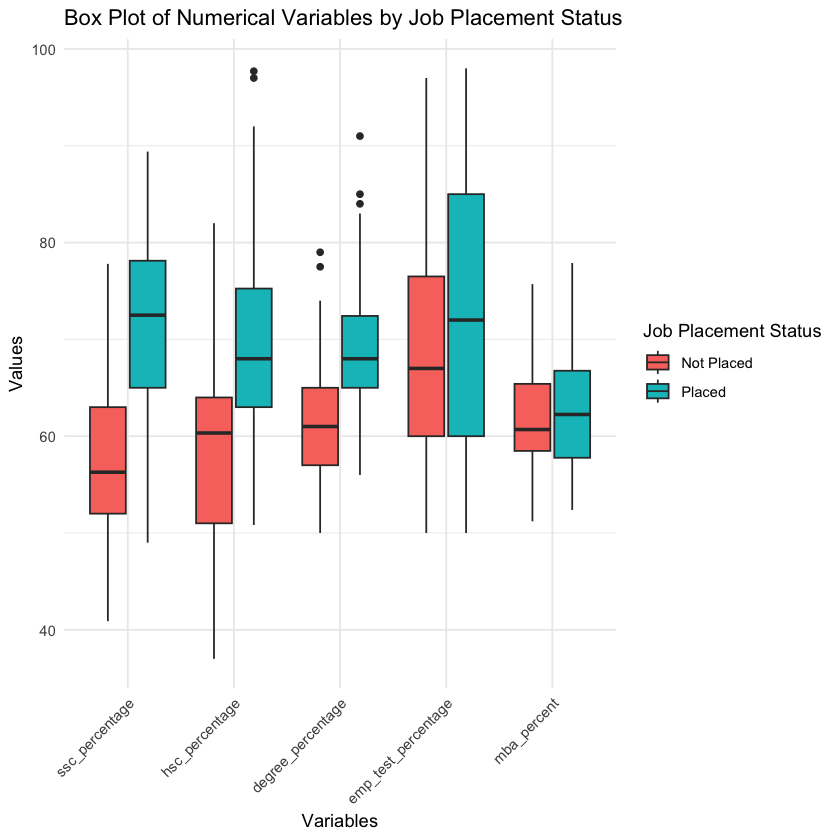

In [51]:
# Melt the data to long format, including numerical variables and status
placement_melted <- melt(placement, id.vars = "status", 
                         measure.vars = c("ssc_percentage", "hsc_percentage", "degree_percentage", "emp_test_percentage", "mba_percent"),
                         variable.name = "Variable", value.name = "Value")
# Create a box plot for all numerical variables with respect to status
ggplot(placement_melted, aes(x = Variable, y = Value, fill = status)) +
  geom_boxplot() +
  labs(title = "Box Plot of Numerical Variables by Job Placement Status", x = "Variables", y = "Values", fill = "Job Placement Status") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

The box plots reveal some differences in academic and test performance between placed and not placed students. Higher percentages in all 5 categories show higher medians for placed students. However, even the greatest gap between medians of placed and that of not placed is around 10%. Therefore, score percentages in k12 schools, college, and graduate school do not play a significant role in job placement of this dataset. 

#### Bar Charts

Now, we will analyze the categorical variables and in my opinion, this 

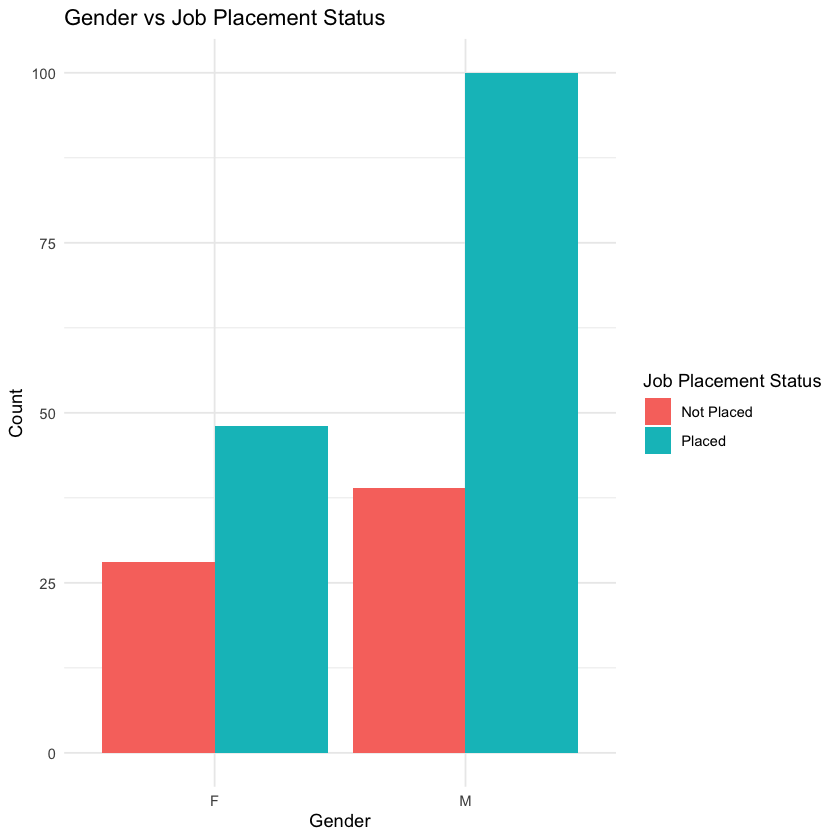

In [54]:
# Bar chart for gender with respect to status
ggplot(placement, aes(x = gender, fill = status)) +
  geom_bar(position = "dodge") +
  labs(title = "Gender vs Job Placement Status", x = "Gender", y = "Count", fill = "Job Placement Status") +
  theme_minimal()

The bar chart shows that males have a higher placement rate compared to females. There is a significant gap in the number of males placed versus not placed, while the distribution for females is more balanced, though still more females are placed than not placed. This suggests that gender may have some influence on job placement, with males having a higher likelihood of being placed.

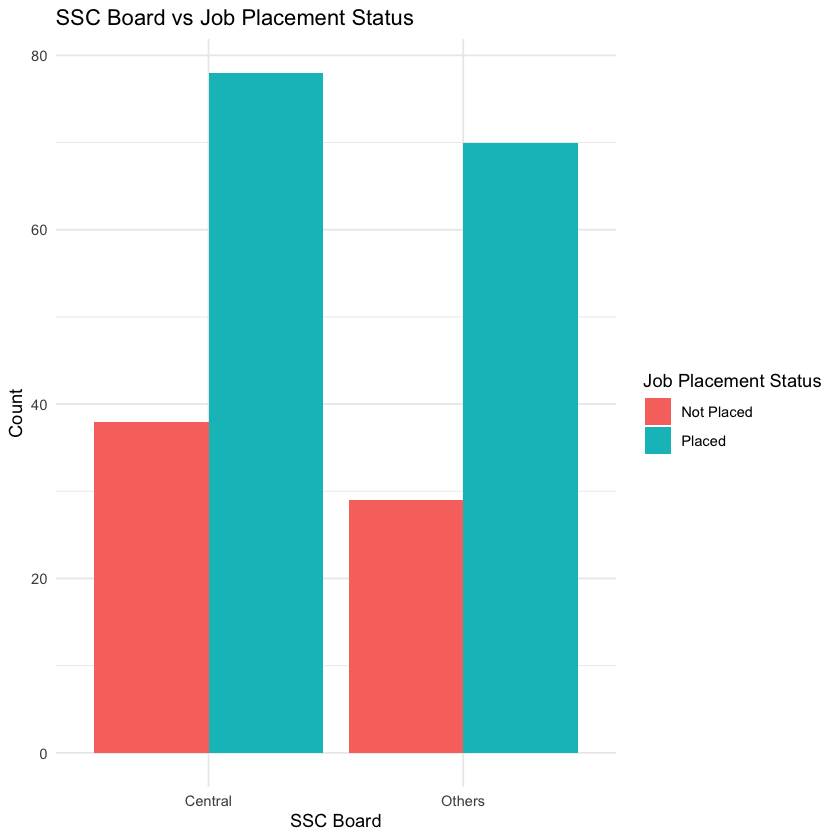

In [56]:
# Bar chart for ssc_board with respect to status
ggplot(placement, aes(x = ssc_board, fill = status)) +
  geom_bar(position = "dodge") +
  labs(title = "SSC Board vs Job Placement Status", x = "SSC Board", y = "Count", fill = "Job Placement Status") +
  theme_minimal()

The Central board students show a slightly higher rate of placement compared to the Others board students. While both boards have more students placed than not placed, the central board students have a slightly better outcome. This may indicate that employers tend to favor students from the central board, or that central board students have higher academic achievements, which contribute to better job placement opportunities.

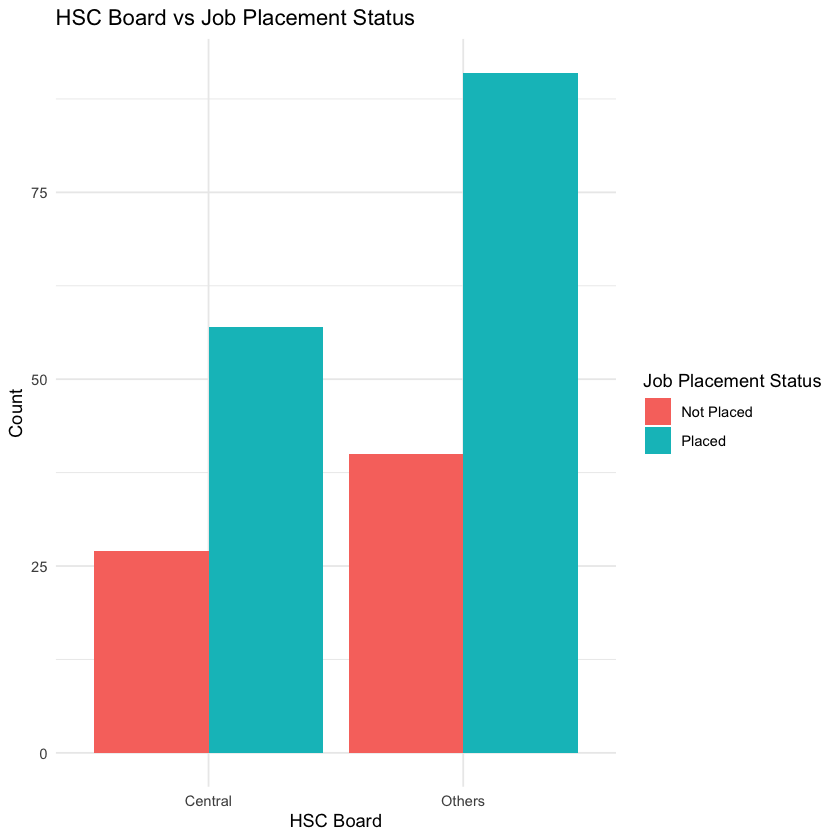

In [58]:
# Bar chart for hsc_board with respect to status
ggplot(placement, aes(x = hsc_board, fill = status)) +
  geom_bar(position = "dodge") +
  labs(title = "HSC Board vs Job Placement Status", x = "HSC Board", y = "Count", fill = "Job Placement Status") +
  theme_minimal()

Similar to the SSC board results, students from the Others HSC board are placed at a higher rate than students from the Central board. This pattern contrasts with the SSC board findings, suggesting that the relationship between school boards and job placement outcomes may change at the higher secondary level. It is possible that factors like specific subjects or extracurricular activities play a more significant role in job placement at this stage.

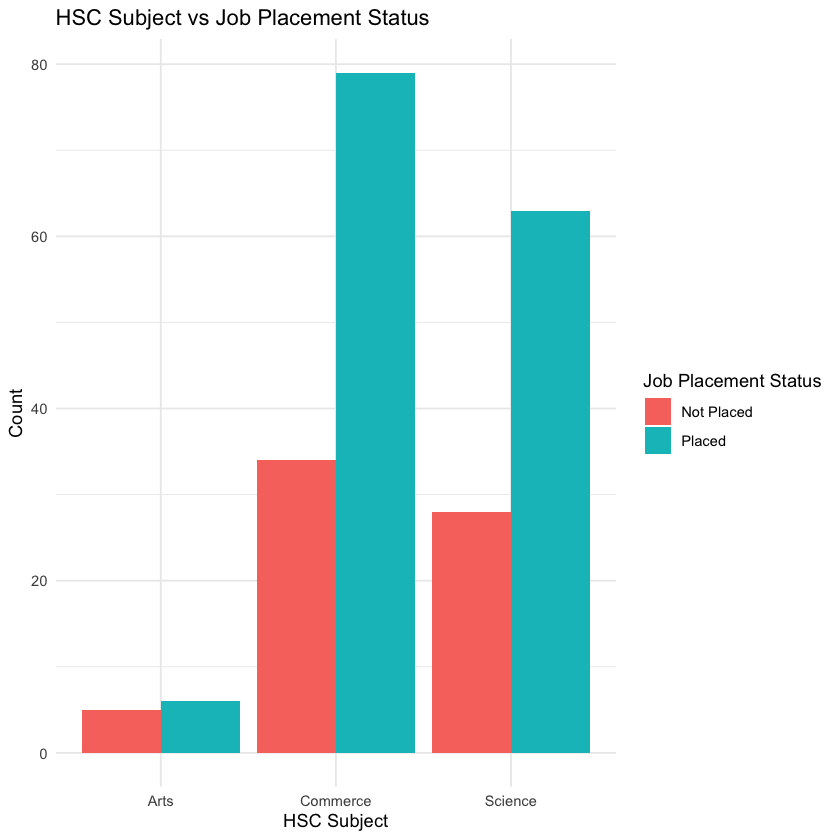

In [61]:
# Bar chart for hsc_subject with respect to status
ggplot(placement, aes(x = hsc_subject, fill = status)) +
  geom_bar(position = "dodge") +
  labs(title = "HSC Subject vs Job Placement Status", x = "HSC Subject", y = "Count", fill = "Job Placement Status") +
  theme_minimal()

Students who pursued Commerce in higher secondary school have the highest placement rates, followed by students from Science. Arts students show the lowest placement rate. This suggests that commerce-related subjects may provide better job placement opportunities, possibly due to the relevant business skills in the job market. Science students also have a reasonable placement rate, likely due to opportunities in technical industries.

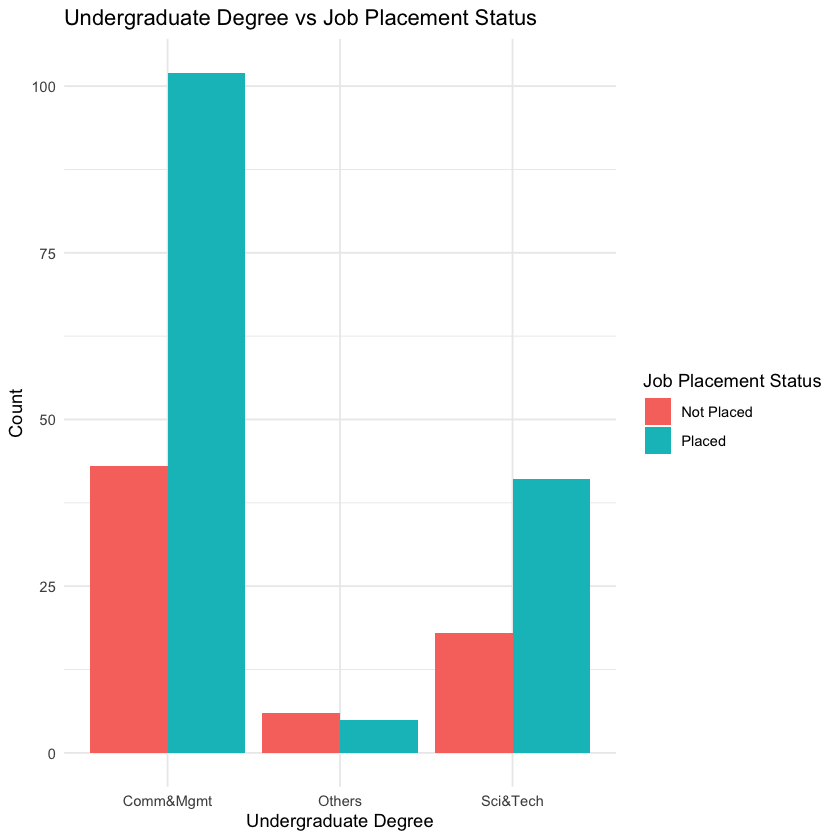

In [63]:
# Bar chart for undergrad_degree with respect to status
ggplot(placement, aes(x = undergrad_degree, fill = status)) +
  geom_bar(position = "dodge") +
  labs(title = "Undergraduate Degree vs Job Placement Status", x = "Undergraduate Degree", y = "Count", fill = "Job Placement Status") +
  theme_minimal()

Students with degrees in Commerce & Management (Comm&Mgmt) have significantly higher placement rates compared to those in Science & Technology (Sci&Tech) or other degrees. This indicates that employers may favor students with business-related degrees, possibly due to the demand for skills in finance, marketing, and management. Students with Sci&Tech degrees also have a higher placement rate compared to those with Other degrees, which suggests that technical degrees still offer some job placement advantages.

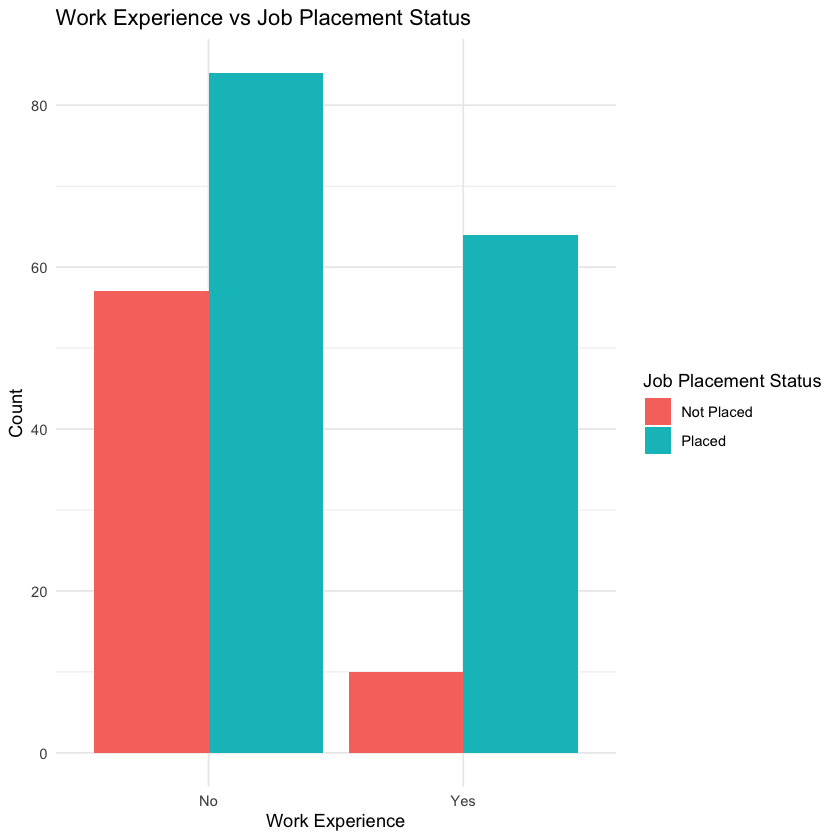

In [66]:
# Bar chart for work_experience with respect to status
ggplot(placement, aes(x = work_experience, fill = status)) +
  geom_bar(position = "dodge") +
  labs(title = "Work Experience vs Job Placement Status", x = "Work Experience", y = "Count", fill = "Job Placement Status") +
  theme_minimal()

The chart shows that students with no work experience have a much higher placement rate compared to those with work experience. This suggests that new graduates tend to be more favored in the job market's context of this dataset. 

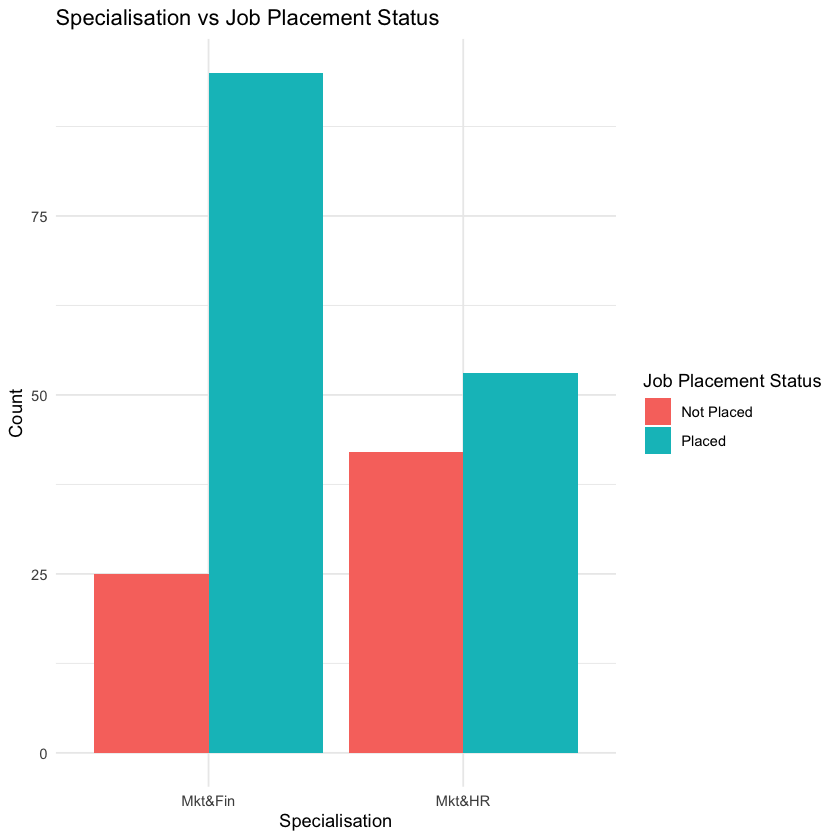

In [68]:
# Bar chart for specialisation with respect to status
ggplot(placement, aes(x = specialisation, fill = status)) +
  geom_bar(position = "dodge") +
  labs(title = "Specialisation vs Job Placement Status", x = "Specialisation", y = "Count", fill = "Job Placement Status") +
  theme_minimal()

Students specializing in Marketing & Finance (Mkt&Fin) have a much higher placement rate compared to those specializing in Marketing & Human Resources (Mkt&HR). This suggests that job placement opportunities are better for students with a finance background, possibly due to the high demand for financial analysts, accountants, and finance managers. Marketing and HR specializations may not offer the same level of demand, which could explain the lower placement rate for Mkt&HR students.

<a name="model-setup"></a>
## IV. Model Setup

<a name="training-&-test-splitting"></a>
### Training & Test Spliting
In this step, I’m dividing the data into training and test sets. The training set will be used to train the model, while the test set will evaluate its performance to ensure it performs well on new, unseen data. To maintain consistency in the distribution of an important variable, I’ll add status as a stratification variable when splitting the data. This way, I can ensure that the distribution of this key variable remains similar between the training and test sets, which will help improve the reliability of the model’s performance.

In [78]:
# Set the seed for reproducibility
set.seed(123)

# Split the data into training and testing sets with stratification
split_data <- initial_split(placement, prop = 0.75, strata = status)

training_set <- training(split_data)
test_set <- testing(split_data)

In [79]:
dim(training_set)  # The training dataset consists of 161 rows and 14 columns.

[1] 161  14

In [81]:
dim(test_set)  # The testing dataset consists of 54 rows and 14 columns.

[1] 54 14

In [82]:
# View the proportion of 'status' in the training and test sets to ensure stratification
table(training_set$status) / nrow(training_set)
table(test_set$status) / nrow(test_set)


Not Placed     Placed 
  0.310559   0.689441 


Not Placed     Placed 
 0.3148148  0.6851852 

The status proportions are nearly identical in both training and test sets, with around 31% Not Placed and 69% Placed

<a name="k-fold-cross-validation"></a>
### K-Fold Cross-Validation

In [85]:
# Set up 10-fold cross-validation
cv_splits <- vfold_cv(training_set, v = 10, strata = status)

<a name="recipe"></a>
### Recipe

In [87]:
placement_recipe <- recipe(status ~ gender + ssc_percentage + ssc_board + hsc_percentage + 
                           hsc_board + hsc_subject + degree_percentage + undergrad_degree + 
                           work_experience + specialisation + emp_test_percentage + 
                           mba_percent, data = training_set) %>%
  step_dummy(all_nominal_predictors()) %>%  # Convert categorical variables to dummy variables
  step_normalize(all_numeric_predictors())  %>%  # Normalize the numeric predictors
  step_center(all_numeric_predictors()) %>%  # Center all numeric predictors
  step_scale(all_numeric_predictors())  # Scale all numeric predictors

<a name="model-building"></a>
## V. Model Building
Since I am predicting job placement based on various predictors like gender, SSC/HSC percentages, degree percentages, work experience, and specialisation, the choice of models should be guided by the nature of our outcome variable: status (Placed or Not Placed). Given that status is a categorical variable with two levels (binary classification), the 5 types of models below, in my opinion, might work well for my analysis:

* #### Logistic Regression using Elastic Net:
Logistic Regression is a classic method for binary classification tasks like job placement. It provides probabilities for being "Placed" or "Not Placed" based on the predictors. Logistic regression is particularly useful for interpreting the effects of different predictors, such as the impact of degree percentage or work experience on the likelihood of placement. It offers insights into how each variable influences the placement outcome, making it a solid, interpretable option for this binary classification task.

* #### Gradient Boosted Trees:
Gradient Boosted Trees are an ensemble learning method that builds multiple decision trees in sequence, with each new tree focusing on correcting the errors of the previous ones. This method is robust to overfitting and works well when there are non-linear relationships between predictors and the outcome. For job placement prediction, this approach can capture complex interactions between academic performance, gender, and work experience, offering a powerful and flexible model that can adapt to diverse data patterns.

* #### Support Vector Machines (SVM):
Support Vector Machines are effective when the boundary between classes (Placed vs. Not Placed) is not clearly linear. Using an appropriate kernel, SVM can handle complex, non-linear relationships between variables. For predicting job placement, SVM can model subtle patterns between predictors like specialisation, academic scores, and work experience, allowing the model to separate placed and non-placed students with higher precision.

<a name="model-specification"></a>
### Model Specification
First, I will sett the mode to regression and specify any model-specific parameters.



In [90]:
# Gradient Boosted Trees
boosted_tree_spec <- boost_tree(min_n = tune(), 
                                trees = tune(), 
                                learn_rate = tune()) %>%
  set_mode("classification") %>%
  set_engine("xgboost")  

# Log Reg
elastic_net_spec <- logistic_reg(penalty = tune(), mixture = tune()) %>%
  set_mode("classification") %>%
  set_engine("glmnet")  

# SVM
svm_spec <- svm_rbf(cost = tune(),
                    rbf_sigma = tune()) %>%
  set_mode("classification") %>%
  set_engine("kernlab")  

<a name="workflow"></a>
### Workflow

Next, create workflows that pair the model specifications with the recipe.

In [93]:
# Gradient Boosted Trees
boosted_tree_workflow <- workflow() %>%
  add_model(boosted_tree_spec) %>%
  add_recipe(placement_recipe)

# Elastic Net
elastic_net_workflow <- workflow() %>%
  add_model(elastic_net_spec) %>%
  add_recipe(placement_recipe)

# SVM
svm_workflow <- workflow() %>%
  add_model(svm_spec) %>%
  add_recipe(placement_recipe)

<a name="grids"></a>
### Grids

Set up tuning grids for the models that require hyperparameter tuning.

In [96]:
# Gradient Boosted Trees
grid_gbt <- grid_regular(
  trees(range = c(200, 600)),  # Number of trees
  min_n(range=c(1, 2)),
  learn_rate(range = c(0.05, 0.1), trans = identity_trans()),  # Learning rate
  levels = 5
)

# Log Reg
elastic_net_grid <- grid_regular(
  penalty(range = c(0.01, 0.1)),  
  mixture(range = c(0, 0.1)),  
  levels = 5  
)

# SVM
svm_grid <- grid_regular(
  cost(range = c(1, 10)), 
  rbf_sigma(range = c(-5, -3)),  
  levels = 5  
)

<a name="tune-grid"></a>
### Tune-Grid

In [98]:
# Gradient Boosted Trees
boosted_tree_results <- tune_grid(
  boosted_tree_workflow,
  resamples = cv_splits,
  grid = grid_gbt,
  metrics = metric_set(roc_auc, accuracy)
)

collect_metrics(boosted_tree_results)

trees,min_n,learn_rate,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
200,1,0.0500,accuracy,binary,0.8507353,10,0.02983358,Preprocessor1_Model01
200,1,0.0500,roc_auc,binary,0.9048485,10,0.03234911,Preprocessor1_Model01
300,1,0.0500,accuracy,binary,0.8448529,10,0.02972060,Preprocessor1_Model02
300,1,0.0500,roc_auc,binary,0.9048485,10,0.03011457,Preprocessor1_Model02
400,1,0.0500,accuracy,binary,0.8323529,10,0.03228975,Preprocessor1_Model03
400,1,0.0500,roc_auc,binary,0.9065152,10,0.02879944,Preprocessor1_Model03
500,1,0.0500,accuracy,binary,0.8323529,10,0.03228975,Preprocessor1_Model04
500,1,0.0500,roc_auc,binary,0.9048485,10,0.02809534,Preprocessor1_Model04
600,1,0.0500,accuracy,binary,0.8323529,10,0.03228975,Preprocessor1_Model05


In [100]:
# Log Reg
elastic_net_results <- tune_grid(
  elastic_net_workflow,
  resamples = cv_splits,
  grid = elastic_net_grid,
  metrics = metric_set(roc_auc, accuracy)
)
collect_metrics(elastic_net_results)

penalty,mixture,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1.023293,0.000,accuracy,binary,0.7143382,10,0.018914281,Preprocessor1_Model01
1.023293,0.000,roc_auc,binary,0.9106061,10,0.022861556,Preprocessor1_Model01
1.077705,0.000,accuracy,binary,0.7018382,10,0.012430724,Preprocessor1_Model02
1.077705,0.000,roc_auc,binary,0.9087879,10,0.023265019,Preprocessor1_Model02
1.135011,0.000,accuracy,binary,0.6955882,10,0.006315735,Preprocessor1_Model03
1.135011,0.000,roc_auc,binary,0.9087879,10,0.023265019,Preprocessor1_Model03
1.195364,0.000,accuracy,binary,0.6955882,10,0.006315735,Preprocessor1_Model04
1.195364,0.000,roc_auc,binary,0.9087879,10,0.023265019,Preprocessor1_Model04
1.258925,0.000,accuracy,binary,0.6955882,10,0.006315735,Preprocessor1_Model05


In [101]:
# SVM model
svm_results <- tune_grid(
  svm_workflow,
  resamples = cv_splits,
  grid = svm_grid,
  metrics = metric_set(roc_auc, accuracy)
)
collect_metrics(svm_results)

cost,rbf_sigma,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2.000000,1.000000e-05,accuracy,binary,0.6893382,10,0.001838235,Preprocessor1_Model01
2.000000,1.000000e-05,roc_auc,binary,0.9246970,10,0.020698508,Preprocessor1_Model01
9.513657,1.000000e-05,accuracy,binary,0.6893382,10,0.001838235,Preprocessor1_Model02
9.513657,1.000000e-05,roc_auc,binary,0.9265152,10,0.019900849,Preprocessor1_Model02
45.254834,1.000000e-05,accuracy,binary,0.6893382,10,0.001838235,Preprocessor1_Model03
45.254834,1.000000e-05,roc_auc,binary,0.9265152,10,0.019900849,Preprocessor1_Model03
215.269482,1.000000e-05,accuracy,binary,0.6893382,10,0.001838235,Preprocessor1_Model04
215.269482,1.000000e-05,roc_auc,binary,0.9265152,10,0.019900849,Preprocessor1_Model04
1024.000000,1.000000e-05,accuracy,binary,0.8573529,10,0.029374977,Preprocessor1_Model05


<a name="metrics-collection"></a>
### Metrics Collection
To evaluate and compare the models, I will use the mean and standard errors of the performance metric and focus on the area under the ROC curve (AUC). By creating a summary table with the mean and standard error for metrics like ROC AUC and accuracy for each model, I can assess and compare their performance. This approach allows for a clearer understanding of how each model performs relative to the others.




In [104]:
all_results <- bind_rows(
  collect_metrics(boosted_tree_results) %>% mutate(model = "Gradient Boosted Trees"),
  collect_metrics(elastic_net_results) %>% mutate(model = "Logistic Regression using Elastic-Net"),
  collect_metrics(svm_results) %>% mutate(model = "SVM")
)

print(all_results)

# A tibble: 200 × 14
   trees min_n learn_rate .metric  .estimator  mean     n std_err .config  model
   <int> <int>      <dbl> <chr>    <chr>      <dbl> <int>   <dbl> <chr>    <chr>
 1   200     1       0.05 accuracy binary     0.851    10  0.0298 Preproc… Grad…
 2   200     1       0.05 roc_auc  binary     0.905    10  0.0323 Preproc… Grad…
 3   300     1       0.05 accuracy binary     0.845    10  0.0297 Preproc… Grad…
 4   300     1       0.05 roc_auc  binary     0.905    10  0.0301 Preproc… Grad…
 5   400     1       0.05 accuracy binary     0.832    10  0.0323 Preproc… Grad…
 6   400     1       0.05 roc_auc  binary     0.907    10  0.0288 Preproc… Grad…
 7   500     1       0.05 accuracy binary     0.832    10  0.0323 Preproc… Grad…
 8   500     1       0.05 roc_auc  binary     0.905    10  0.0281 Preproc… Grad…
 9   600     1       0.05 accuracy binary     0.832    10  0.0323 Preproc… Grad…
10   600     1       0.05 roc_auc  binary     0.905    10  0.0282 Preproc… Grad…
# ℹ 190

<a name="model-result"></a>
## VI. Model Result

In [106]:
final_compare_tibble <- tibble(
  Model = c("Logistic Regression using Elastic-Net", "Gradient Boosted Trees", "SVM"),
  Accuracy_Mean = c(
    mean(all_results$mean[all_results$model == "Logistic Regression using Elastic-Net" & all_results$.metric == "accuracy"]),
    mean(all_results$mean[all_results$model == "Gradient Boosted Trees" & all_results$.metric == "accuracy"]),
    mean(all_results$mean[all_results$model == "SVM" & all_results$.metric == "accuracy"])
  ),
  Accuracy_StdErr = c(
    mean(all_results$std_err[all_results$model == "Logistic Regression using Elastic-Net" & all_results$.metric == "accuracy"]),
    mean(all_results$std_err[all_results$model == "Gradient Boosted Trees" & all_results$.metric == "accuracy"]),
    mean(all_results$std_err[all_results$model == "SVM" & all_results$.metric == "accuracy"])
  ),
  ROC_AUC_Mean = c(
    mean(all_results$mean[all_results$model == "Logistic Regression using Elastic-Net" & all_results$.metric == "roc_auc"]),
    mean(all_results$mean[all_results$model == "Gradient Boosted Trees" & all_results$.metric == "roc_auc"]),
    mean(all_results$mean[all_results$model == "SVM" & all_results$.metric == "roc_auc"])
  ),
  ROC_AUC_StdErr = c(
    mean(all_results$std_err[all_results$model == "Logistic Regression using Elastic-Net" & all_results$.metric == "roc_auc"]),
    mean(all_results$std_err[all_results$model == "Gradient Boosted Trees" & all_results$.metric == "roc_auc"]),
    mean(all_results$std_err[all_results$model == "SVM" & all_results$.metric == "roc_auc"])
  )
)


final_compare_tibble <- final_compare_tibble %>% 
  arrange(Accuracy_Mean)

print(final_compare_tibble)

# A tibble: 3 × 5
  Model                Accuracy_Mean Accuracy_StdErr ROC_AUC_Mean ROC_AUC_StdErr
  <chr>                        <dbl>           <dbl>        <dbl>          <dbl>
1 Logistic Regression…         0.693         0.00456        0.917         0.0239
2 SVM                          0.779         0.0171         0.931         0.0193
3 Gradient Boosted Tr…         0.839         0.0305         0.905         0.0280


The SVM model stands out for its impressive ROC_AUC score, which is the highest among the compared models. This indicates its superior ability to distinguish between classes. Although its accuracy mean is lower than Gradient Boosted Trees, its strong ROC_AUC score, combined with relatively low standard errors for both accuracy and ROC_AUC, suggests that SVM performs reliably and consistently. This makes SVM a robust choice, especially when the focus is on optimizing classification performance rather than just accuracy.

<a name="model-fitting"></a>
## VII. Model Fitting

In [110]:
# extract the best hyperparameters
best_svm <- select_best(svm_results, metric = "accuracy")

# Finalize the workflow
# combines the preprocessing recipe and model specifications along with the best-tuned parameters into a final workflow.
final_workflow_svm <- finalize_workflow(
  svm_workflow,
  best_svm)

# Fit the final model
# Applies the finalized workflow to the training data
fitted_model_svm <- fit(final_workflow_svm, data = training_set)

summary(fitted_model_svm)

        Length Class      Mode   
pre     3      stage_pre  list   
fit     2      stage_fit  list   
post    1      stage_post list   
trained 1      -none-     logical

<a name="model-testing"></a>
## VIII. Model Testing
First, I will use the fitted Gradient Boosted Trees model to make predictions on my test data set and evaluate its performance.

In [113]:
pred_svm <- predict(fitted_model_svm, new_data = test_set)
pred_vs_actual <- bind_cols(pred_svm, test_set %>% select(status))


test_results <- pred_vs_actual %>% 
  metrics(truth = status, estimate = .pred_class) %>%
  filter(.metric == "accuracy")

test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8333333


The output shows that the SVM model has an accuracy of 0.8333 on the test set. This means the model correctly predicted the job placement status about 83% of the time. It suggests that the model does a good job at identifying whether a candidate is placed or not placed.

<a name="error-analysis"></a>
## IX. Error Analysis

In reviewing the performance of my placement prediction model, although the accuracy is reasonably high, there are a few aspects that need to be explored further to understand the model's limitations and areas for improvement. This error analysis will focus on potential misclassifications, class imbalance, and other challenges that could be affecting the model’s performance.

### 1. Misclassification Analysis:

* #### Overlap in Predictive Features:
The model may struggle to differentiate between candidates with similar educational backgrounds or work experience, particularly in cases where the numerical predictors, like percentages in degree or school exams, are very close. For example, candidates with slightly different SSC or HSC percentages may still share similar placement outcomes, which could confuse the model.

* #### Outliers in the Data:
There could be outliers in the dataset, such as unusually high or low percentages in MBA scores or employment test scores. These extremes could distort the model's understanding, leading to misclassification in those rare cases. These data points might require special handling or be excluded altogether.

### 2. Class Imbalance:

* #### Imbalanced Placement Outcomes:
The dataset could have an imbalance between the number of placed and not placed candidates, leading the model to favor the majority class. This can reduce the model’s ability to correctly predict the minority class (e.g., candidates not placed), as it may tend to lean towards the more frequent "placed" label in ambiguous cases.

![Job Placement4](https://arizonaatwork.com/sites/default/files/styles/banner_style/public/2023-09/yuma%201_0.png?h=d4b05177&itok=VpRSIpn5)

<a name="conclusion"></a>
## X. Conclusion
In this project, we explored the factors influencing job placement outcomes using a dataset containing various educational and demographic variables. The analysis began with data cleaning and preparation, focusing on relevant variables like gender, work experience, academic performance, and specialisation while ensuring no missing values hindered the process. Extensive exploratory data analysis (EDA) followed, where we used visual tools such as histograms, box plots, and correlation matrices to uncover patterns and relationships within the data.

For the modeling phase, we employed several machine learning techniques, including Logistic Regression, Support Vector Machines (SVM), and Gradient Boosted Trees. We used cross-validation to tune the models and assess their performance to maintain robustness and ability to generalize to unseen data. Among these, the Support Vector Machines model emerged as the best performer because it effectively captured the complex relationships between academic and demographic features and job placement status.

The results from our best model revealed significant predictors of placement success, including work experience, degree percentage, and specialization. These insights can help institutions and students alike to focus on improving these areas, ultimately increasing job placement rates. Overall, this project demonstrated the practical application of machine learning in predicting job placement outcomes based on academic and professional profiles.

![Job Placement2](https://i0.wp.com/www.noozhawk.com/wp-content/uploads/2016/02/Career_Connections.jpg?w=630&ssl=1)

<a name="sources"></a>
## XI. Sources
Kaggle. “Job Placement Dataset.” Kaggle, Ahsan81, 2023, https://www.kaggle.com/datasets/ahsan81/job-placement-dataset/data. Accessed 15 Sept. 2024.

“Job Placement Visualization Image.” Placement India, 30 Mar. 2021, https://dynamic.placementindia.com/blog_images/20210330112333_image1.jpg. Accessed 15 Sept. 2024.

“Job Market Analysis Image.” Accountability Resources, Aug. 2020, https://accountabilityresources.com/wp-content/uploads/2020/08/iStock-1138817616-2048x1356.jpg.webp. Accessed 15 Sept. 2024.

“Career Connections Image.” Noozhawk, https://i0.wp.com/www.noozhawk.com/wp-content/uploads/2016/02/Career_Connections.jpg?w=630&ssl=1. Accessed 15 Sept. 2024.

“Yuma Job Placement Banner Image.” ARIZONA@WORK, Arizona, Sept. 2023, https://arizonaatwork.com/sites/default/files/styles/banner_style/public/2023-09/yuma%201_0.png?h=d4b05177&itok=VpRSIpn5. Accessed 15 Sept. 2024.